In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

In [5]:
X_train = joblib.load('../../preprocessed_data/CICIOT_update/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIOT_update/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIOT_update/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIOT_update/Y_test.joblib')

### CNN training

In [6]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.3), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 44, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,313 (177.00 KB)

 Trainable params: 45,313 (177.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9720 - loss: 0.1069 - val_accuracy: 0.9830 - val_loss: 0.0655
Epoch 2/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9825 - loss: 0.0696 - val_accuracy: 0.9834 - val_loss: 0.0605
Epoch 3/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9829 - loss: 0.0649 - val_accuracy: 0.9850 - val_loss: 0.0554
Epoch 4/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9844 - loss: 0.0596 - val_accuracy: 0.9853 - val_loss: 0.0544
Epoch 5/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9844 - loss: 0.0592 - val_accuracy: 0.9855 - val_loss: 0.0526


### LSTM training

In [7]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,121 (82.50 KB)

 Trainable params: 21,121 (82.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9309 - loss: 0.1882 - val_accuracy: 0.9771 - val_loss: 0.0826
Epoch 2/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9791 - loss: 0.0803 - val_accuracy: 0.9800 - val_loss: 0.0746
Epoch 3/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9801 - loss: 0.0738 - val_accuracy: 0.9811 - val_loss: 0.0694
Epoch 4/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9821 - loss: 0.0668 - val_accuracy: 0.9834 - val_loss: 0.0627
Epoch 5/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9831 - loss: 0.0640 - val_accuracy: 0.9829 - val_loss: 0.0641


### AE-LSTM

In [8]:
input_dim = X_train.shape[1]  # n_features

# encoder
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 46, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,153 (82.63 KB)

 Trainable params: 21,153 (82.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9382 - loss: 0.1801 - val_accuracy: 0.9790 - val_loss: 0.0812
Epoch 2/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9797 - loss: 0.0795 - val_accuracy: 0.9804 - val_loss: 0.0757
Epoch 3/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9797 - loss: 0.0791 - val_accuracy: 0.9817 - val_loss: 0.0711
Epoch 4/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9816 - loss: 0.0712 - val_accuracy: 0.9823 - val_loss: 0.0669
Epoch 5/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9830 - loss: 0.0664 - val_accuracy: 0.9835 - val_loss: 0.0644


Let's save our models

In [11]:
CNN_model.save("../../models/cnn_ciciot_updated_model.keras")

In [12]:
LSTM_model.save("../../models/lstm_ciciot_updated_model.keras")

In [13]:
AE_LSTM_model.save("../../models/ae-lstm_ciciot_updated_model.keras")

In [21]:
from keras.utils import plot_model
import pydot

from keras.models import load_model

cnn_loaded = load_model('../../models/cnn_ciciot_updated_model.keras')
lstm_loaded = load_model('../../models/lstm_ciciot_updated_model.keras')
ae_lstm_loaded = load_model('../../models/ae-lstm_ciciot_updated_model.keras')

plot_model(cnn_loaded, to_file='../../results/CICIOT_updated/CNN_model.png', show_shapes=True, show_layer_names=True)
plot_model(lstm_loaded, to_file='../../results/CICIOT_updated/LSTM_model.png', show_shapes=True, show_layer_names=True)
plot_model(ae_lstm_loaded, to_file='../../results/CICIOT_updated/AE-LSTM_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.
You must install pydot (`pip install pydot`) for `plot_model` to work.
You must install pydot (`pip install pydot`) for `plot_model` to work.


### CNN metrics

2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.99     34081
     Attacks       1.00      0.97      0.99     34081

    accuracy                           0.99     68162
   macro avg       0.99      0.99      0.99     68162
weighted avg       0.99      0.99      0.99     68162

Test Loss: 0.0526
Test Accuracy: 0.9855


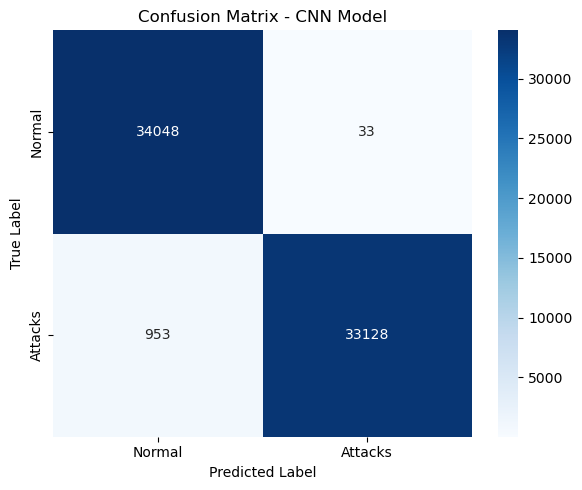

Attacks detected (True Positive) : 33128
Normal traffic detected (True Negative) : 34048
Attacks missed (False Negative) : 953
False alarms (False Positive) : 33


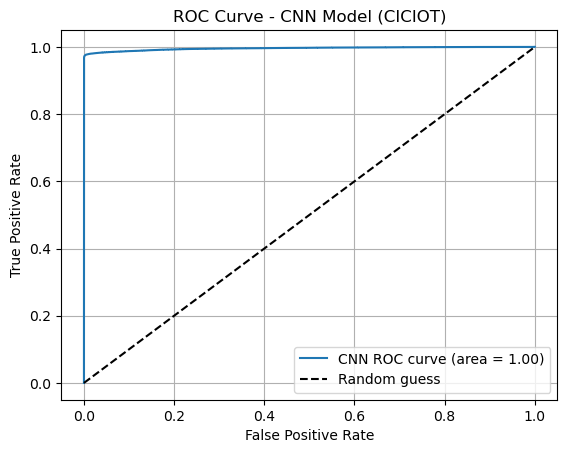

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### LSTM metrics

2131/2131 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98     34081
     Attacks       1.00      0.97      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.98      0.98      0.98     68162
weighted avg       0.98      0.98      0.98     68162

Test Loss: 0.0526
Test Accuracy: 0.9855


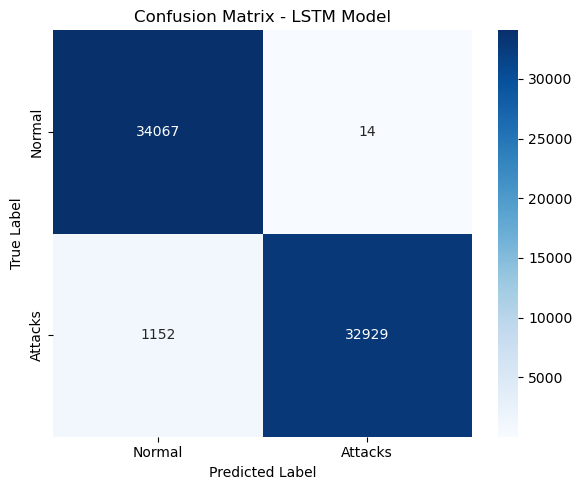

Attacks detected (True Positive) : 32929
Normal traffic detected (True Negative) : 34067
Attacks missed (False Negative) : 1152
False alarms (False Positive) : 14


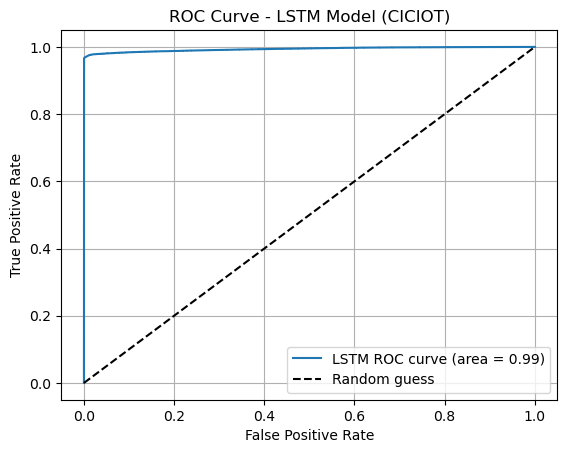

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### AE-LSTM metrics

2131/2131 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98     34081
     Attacks       1.00      0.97      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.98      0.98      0.98     68162
weighted avg       0.98      0.98      0.98     68162

Test Loss: 0.0526
Test Accuracy: 0.9855


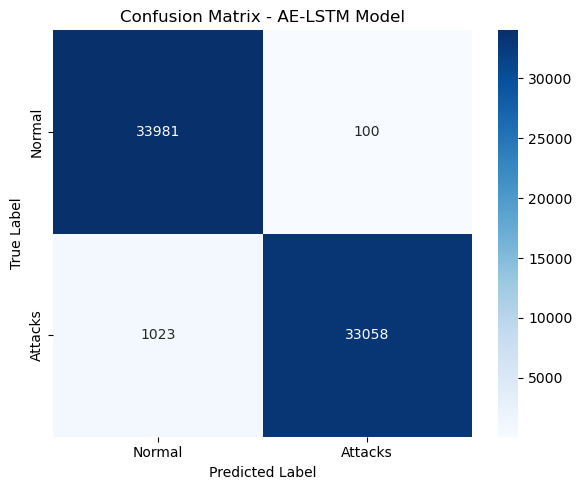

Attacks detected (True Positive) : 33058
Normal traffic detected (True Negative) : 33981
Attacks missed (False Negative) : 1023
False alarms (False Positive) : 100


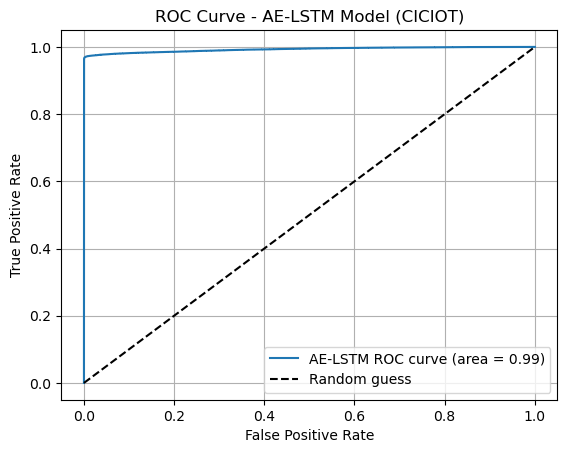

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()